In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-segmentation/README.dataset.txt
/kaggle/input/skin-cancer-segmentation/README.roboflow.txt
/kaggle/input/skin-cancer-segmentation/valid/ISIC_0029387_jpg.rf.c790337dff5b55777a7ceedb7ab82d21.jpg
/kaggle/input/skin-cancer-segmentation/valid/ISIC_0029842_jpg.rf.0b11155f89407f7c49521a795bfab6b1.jpg
/kaggle/input/skin-cancer-segmentation/valid/ISIC_0029273_jpg.rf.e1a7e845b0152533c6a794fe9b1feaba.jpg
/kaggle/input/skin-cancer-segmentation/valid/ISIC_0034122_jpg.rf.a11aba7c75a49ffc1813fe0ab7376eb5.jpg
/kaggle/input/skin-cancer-segmentation/valid/ISIC_0033031_jpg.rf.d2d74399d92b1b2bcecd237d76f3dce7.jpg
/kaggle/input/skin-cancer-segmentation/valid/ISIC_0026548_jpg.rf.44611a49337de8144eceeeae2d58b186.jpg
/kaggle/input/skin-cancer-segmentation/valid/ISIC_0032932_jpg.rf.9b349b5a3012eca59c2b3eb7fb24992c.jpg
/kaggle/input/skin-cancer-segmentation/valid/ISIC_0029646_jpg.rf.9ae62ae010959e6206f2ab98590f6a4b.jpg
/kaggle/input/skin-cancer-segmentation/valid/ISIC_0027131_jpg.rf.46


## 🧩 COCO → YOLO Segmentation Conversion

This section converts the **COCO-format segmentation dataset** into the **YOLO segmentation format**, preparing it for YOLOv8 or YOLOv11 segmentation model training using the **Ultralytics** framework.

---

#### ⚙️ Step 1: Library Installation
The following Python packages are installed:
- **`pycocotools`** → to handle COCO JSON annotations  
- **`tqdm`** → for progress visualization  
- **`ultralytics`** → YOLO training and evaluation tools  

---

#### 🧠 Step 2: Conversion Process
A custom function performs the following operations:
1. **Loads COCO annotations** (`_annotations.coco.json`) for each dataset split (`train`, `valid`, `test`).  
2. **Creates YOLO-style folders** — `images/` and `labels/`.  
3. **Converts segmentation polygons** into **YOLO-normalized coordinates** (values between 0 and 1).  
4. **Generates YOLO label files** (`.txt`) in the format:
5. **Copies images** into the respective YOLO `images/` directory.  
6. **Processes all splits automatically** to ensure consistency.  

---

#### 🔁 Step 3: Split Processing
All three dataset splits — **train**, **valid**, and **test** — are converted sequentially.  
The final YOLO-formatted dataset is saved inside:
/kaggle/working/dataset/
│
├── train/
│ ├── images/
│ └── labels/
│
├── valid/
│ ├── images/
│ └── labels/
│
└── test/
├── images/
└── labels/

---

Each `.txt` file corresponds to its image and contains polygon coordinates describing the segmentation mask in YOLO format.  
All coordinates are **normalized** relative to image width and height.




In [2]:
!pip install pycocotools tqdm
!pip install ultralytics pycocotools tqdm --quiet

import os, json, shutil
from tqdm import tqdm

def coco_to_yolo_segmentation(coco_json, output_dir):
    with open(coco_json, 'r') as f:
        data = json.load(f)

    # Prepare mapping
    id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels'), exist_ok=True)

    # Copy images and make YOLO labels
    for ann in tqdm(data['annotations'], desc=f"Converting {coco_json}"):
        image_id = ann['image_id']
        category_id = ann['category_id'] - 1  # YOLO expects 0-based class IDs
        segmentation = ann['segmentation'][0]

        # Normalize segmentation points
        image_info = next((img for img in data['images'] if img['id'] == image_id), None)
        w, h = image_info['width'], image_info['height']
        seg_norm = [f"{x/w:.6f} {y/h:.6f}" for x, y in zip(segmentation[::2], segmentation[1::2])]

        # Write label file
        label_path = os.path.join(output_dir, 'labels', id_to_filename[image_id].replace('.jpg', '.txt'))
        with open(label_path, 'w') as f:
            f.write(f"{category_id} " + " ".join(seg_norm) + "\n")

        # Move image to images/ folder
        src_img = os.path.join(os.path.dirname(coco_json), id_to_filename[image_id])
        dst_img = os.path.join(output_dir, 'images', id_to_filename[image_id])
        if os.path.exists(src_img):
            shutil.copy(src_img, dst_img)

# === Convert all splits ===
base = "/kaggle/input/skin-cancer-segmentation"
for split in ['train', 'valid', 'test']:
    coco_file = os.path.join(base, split, "_annotations.coco.json")
    out_dir = os.path.join("/kaggle/working/dataset", split)
    coco_to_yolo_segmentation(coco_file, out_dir)

print("✅ Conversion complete! Dataset now ready in /kaggle/working/dataset/")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Converting /kaggle/input/skin-cancer-segmentation/train/_annotations.coco.json: 100%|██████████| 11903/11903 [01:08<00:00, 173.29it/s]
Converting /kaggle/input/skin-cancer-segmentation/valid/_annotations.coco.json: 100%|██████████| 2000/2000 [00:11<00:00, 178.79it/s]
Converting /kaggle/input/skin-cancer-segmentation/test/_annotations.coco.json: 100%|██████████| 1000/1000 [00:05<00:00, 184.60it/s]

✅ Conversion complete! Dataset now ready in /kaggle/working/dataset/




## 🖼️ 1. Sample Image Selection
- Loaded three random images from `/kaggle/working/dataset/train/images/`.
- Displayed them using `matplotlib`.

---

### ⚙️ 2. Intensity Transformation Techniques
Applied the following four transformations on each image:

| Transformation | Description |
|----------------|--------------|
| **Log Transformation** | Expands darker pixels and compresses bright areas using logarithmic scaling. |
| **Gamma Correction (Power-law)** | Adjusts image brightness using γ = 1.5. Values >1 darken the image. |
| **Contrast Stretching** | Linearly maps pixel values to the full range (0–255) to enhance contrast. |
| **Histogram Equalization (CLAHE)** | Improves local contrast using the LAB color model and adaptive histogram equalization. |

Each transformed image was displayed beside the original for comparison.

---

### 🔍 3. Filtering Techniques
Applied three spatial filters and one edge-based filter to smooth or enhance details:

| Filter Type | Method | Effect |
|--------------|---------|--------|
| **Mean Filter** | `cv2.blur()` | Reduces noise by averaging neighboring pixels. |
| **Gaussian Blur** | `cv2.GaussianBlur()` | Smoothens image with a weighted average, preserving edges better. |
| **Median Filter** | `cv2.medianBlur()` | Removes salt-and-pepper noise effectively. |
| **Sobel Edge Filter** | `cv2.Sobel()` | Enhances edges using gradient magnitude of intensity changes. |

---

### 📊 4. Result Visualization
Each transformation and filter was applied and displayed side-by-side:
- **Left:** Original image  
- **Right:** Transformed or filtered result  

This allows visual comparison of the impact of each operation on image brightness, contrast, and detail sharpness.


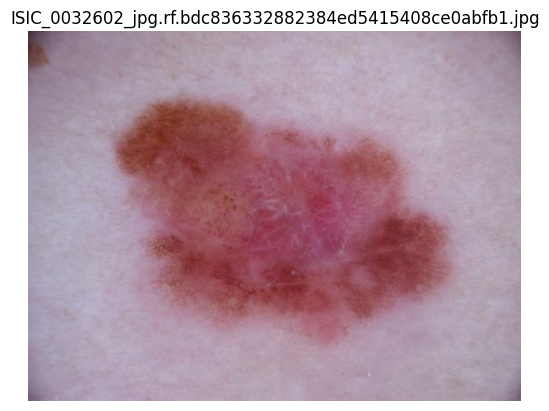

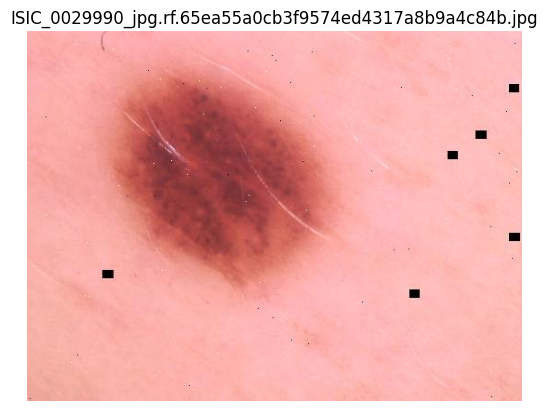

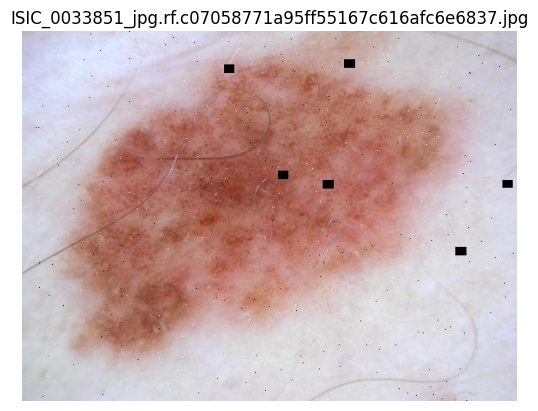

In [3]:
import os
import cv2
import random
import matplotlib.pyplot as plt

train_path = "/kaggle/working/dataset/train/images"  # change if needed

# Get all image filenames
image_files = [f for f in os.listdir(train_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Pick 3 random images
sample_files = random.sample(image_files, 3)

# Load and convert to RGB
images = [cv2.cvtColor(cv2.imread(os.path.join(train_path, img)), cv2.COLOR_BGR2RGB) for img in sample_files]

# Display the images
for i, img in enumerate(images):
    plt.imshow(img)
    plt.title(sample_files[i])
    plt.axis('off')
    plt.show()


In [4]:
# Log Transformation
def log_transform(img):
    c = 255 / np.log(1 + np.max(img))
    log_img = c * np.log(1 + img.astype(np.float32))
    return np.uint8(log_img)

In [5]:
# Gamma Correction
def gamma_correction(img, gamma=1.5):
    img_float = img / 255.0
    gamma_img = np.power(img_float, gamma) * 255
    return np.uint8(gamma_img)

In [6]:
# Contrast Stretching
def contrast_stretch(img):
    in_min = np.min(img)
    in_max = np.max(img)
    out_img = (img - in_min) * (255 / (in_max - in_min))
    return np.uint8(out_img)

In [7]:
# CLAHE (Histogram Equalization)
def clahe_rgb(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge([cl, a, b])
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

--- Image: ISIC_0033967_jpg.rf.a92980f86df102f24f05e3fd2a9f35c1.jpg ---


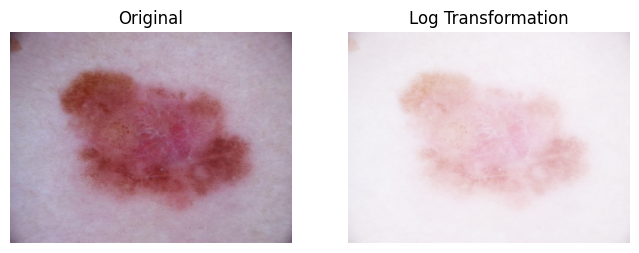

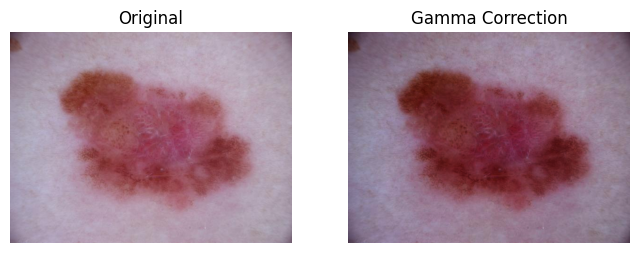

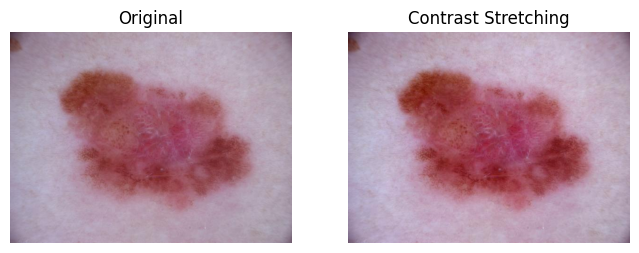

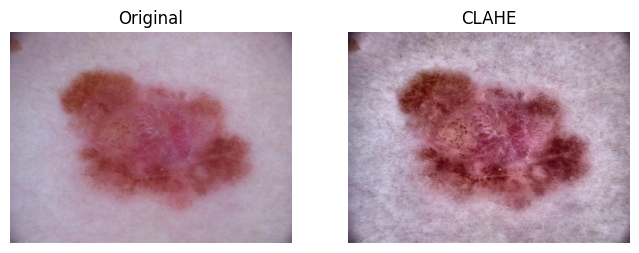

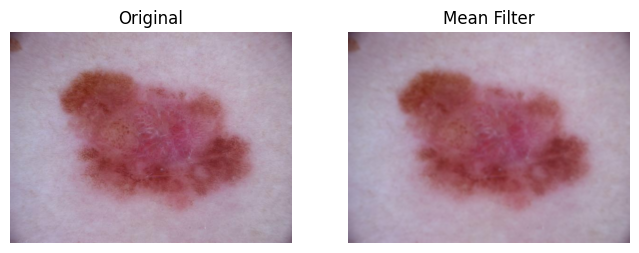

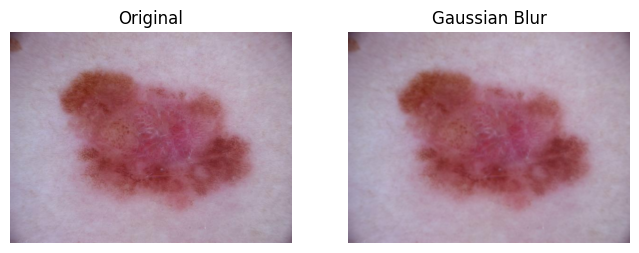

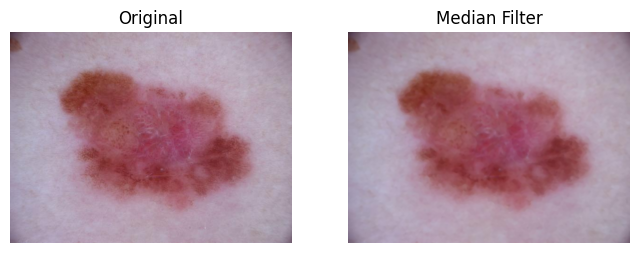

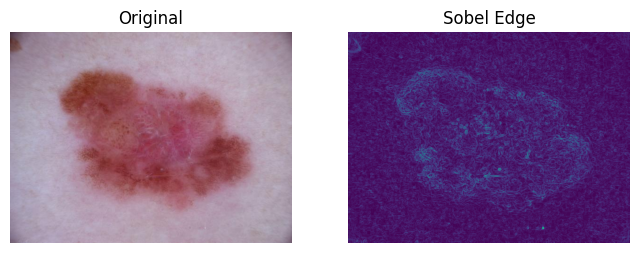

--- Image: ISIC_0033461_jpg.rf.9f4853d9d0ab0696dc45890f3f451e1a.jpg ---


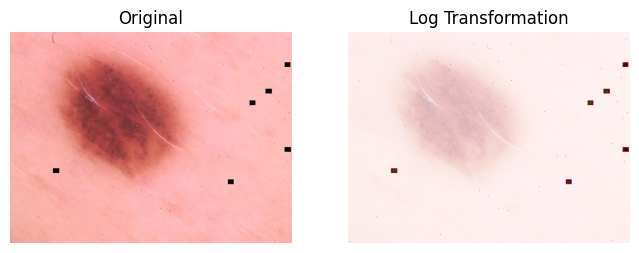

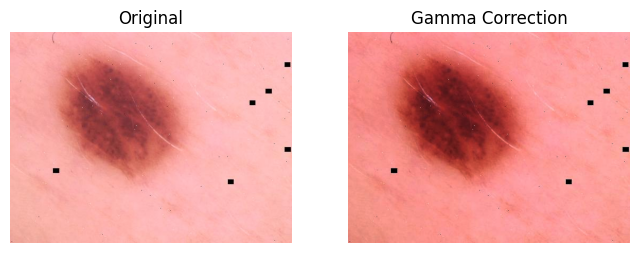

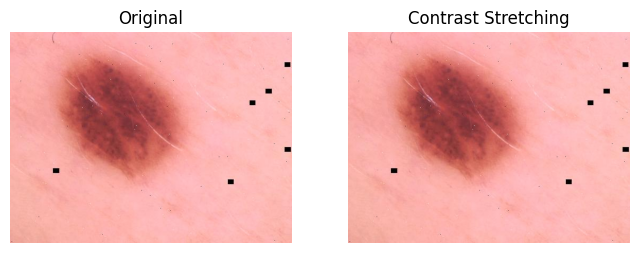

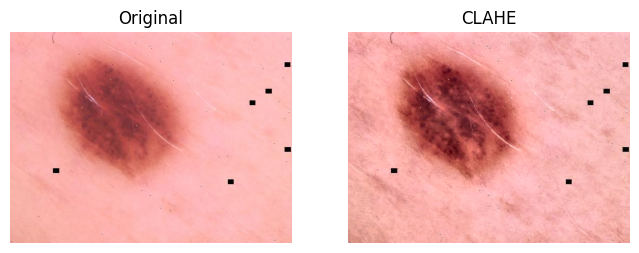

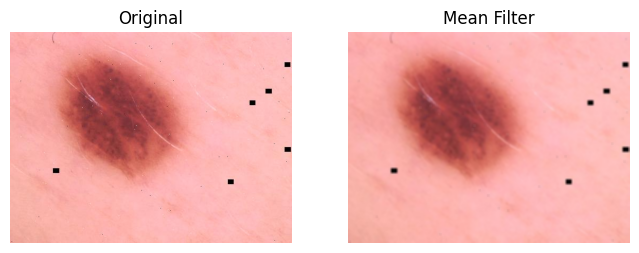

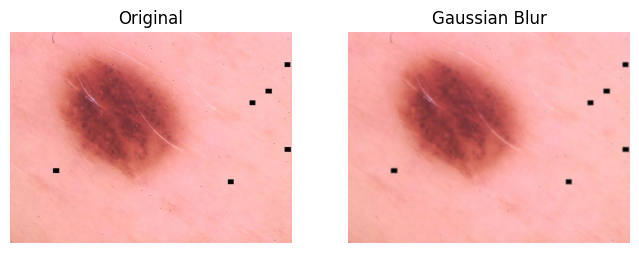

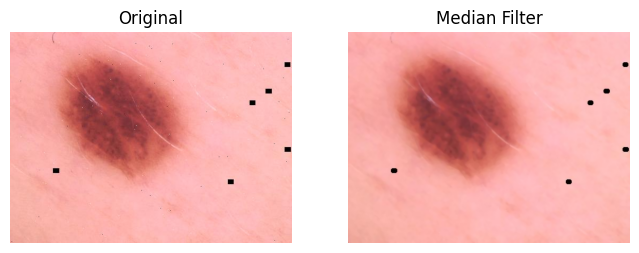

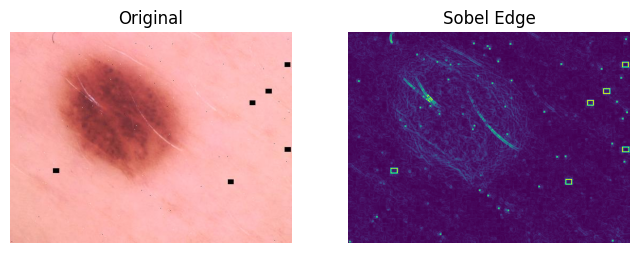

--- Image: ISIC_0031970_jpg.rf.d6311f7337dc91a4824630e682e50e53.jpg ---


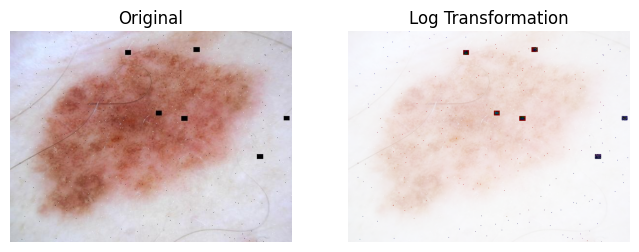

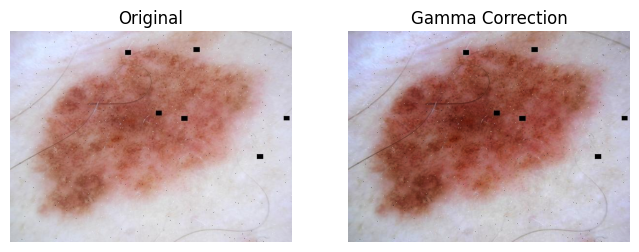

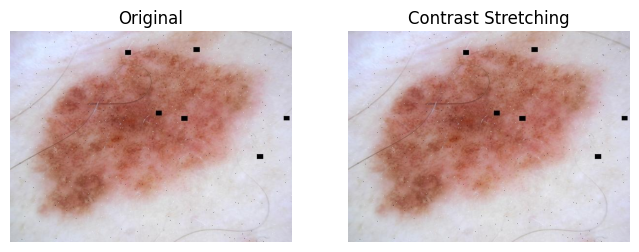

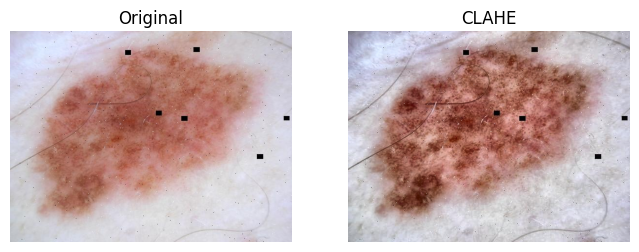

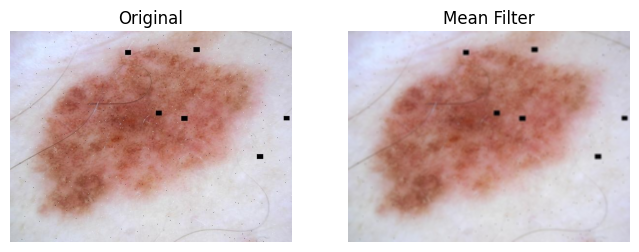

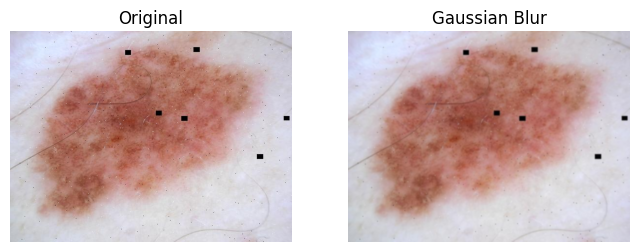

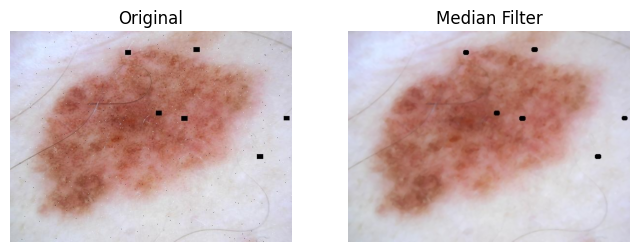

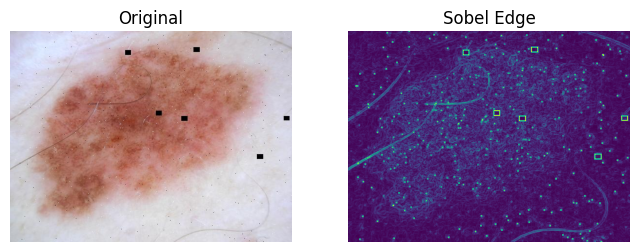

In [8]:
# --- 3. Define Filtering Operations ---
def apply_filters(img):
    filters = {}
    filters['Mean Filter'] = cv2.blur(img, (5,5))
    filters['Gaussian Blur'] = cv2.GaussianBlur(img, (5,5), 0)
    filters['Median Filter'] = cv2.medianBlur(img, 5)
    # Sobel Edge Enhancement
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = cv2.magnitude(sobelx, sobely)
    filters['Sobel Edge'] = np.uint8(np.clip(sobel_combined, 0, 255))
    return filters

# --- 4. Helper function to display before-and-after ---
def show_results(original, transformed, title):
    plt.figure(figsize=(8,5))
    plt.subplot(1,2,1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(transformed)
    plt.title(title)
    plt.axis('off')
    plt.show()
# --- 5. Apply transformations and display results ---
for i, img in enumerate(images):
    print(f"--- Image: {image_files[i]} ---")
    
    # Intensity Transformations
    log_img = log_transform(img)
    gamma_img = gamma_correction(img, gamma=1.5)
    contrast_img = contrast_stretch(img)
    clahe_img = clahe_rgb(img)
    
    show_results(img, log_img, "Log Transformation")
    show_results(img, gamma_img, "Gamma Correction")
    show_results(img, contrast_img, "Contrast Stretching")
    show_results(img, clahe_img, "CLAHE")
    
    # Filtering
    filters = apply_filters(img)
    for f_name, f_img in filters.items():
        show_results(img, f_img, f_name)

## 🗂️ Dataset Configuration (dataset.yaml)

Before training the YOLO model, a configuration file named **`dataset.yaml`** was created to define dataset paths and class labels.

In [9]:
%%writefile dataset.yaml


train: /kaggle/working/dataset/train/images
val: /kaggle/working/dataset/valid/images
test: /kaggle/working/dataset/test/images
nc: 2
names: ['affected','non']


Writing dataset.yaml


In [10]:
!cat dataset.yaml



train: /kaggle/working/dataset/train/images
val: /kaggle/working/dataset/valid/images
test: /kaggle/working/dataset/test/images
nc: 2
names: ['affected','non']


In [11]:
# Install ultralytics without installing any dependencies
!pip -q install --upgrade ultralytics --no-deps


## 🚀 YOLOv8 Segmentation Model Training

This section covers **training a YOLOv8 segmentation model** using the Ultralytics framework with the previously prepared dataset.

---

### ⚙️ Step 1: Import YOLOv8
- The pretrained YOLOv8 segmentation model (`yolov8n-seg.pt`) is imported.
- Additional libraries (`os`, `glob`, `yaml`) are used to verify dataset files and paths.

---

### 🗂️ Step 2: Load Dataset Configuration
- The dataset YAML file (`/kaggle/working/dataset.yaml`) defines paths for **train**, **validation**, and **test** images, the **number of classes**, and their **names** (`['affected', 'non']`).
- The YAML file is loaded and printed to confirm correct paths and class settings.
- A quick check counts the number of files in each split to ensure all images are accessible.

---

### 🏋️ Step 3: Train the YOLOv8 Model
- Training parameters:
  - `data` → path to the dataset YAML file
  - `epochs=50` → number of training iterations
  - `imgsz=640` → input image size
  - `batch=12` → batch size (adjustable for GPU memory)
  - `workers=2` → number of data loader workers
  - `device=0` → GPU device ID (`'cpu'` for CPU training)
  - `patience=10` → early stopping patience
  - `save=True` → save the best weights
  - `pretrained=True` → start from pretrained weights
  - `optimizer="auto"` → automatically selects optimizer
  - `amp=True` → mixed precision for faster GPU training
  - `project` and `name` → define the folder for saving results

- After training, the **best weights** are automatically saved as:


In [12]:
# === Step 1: Import YOLOv8 ===
from ultralytics import YOLO
import os
import glob
import yaml

# === Step 2: Load pretrained YOLOv8 segmentation model ===
# Options: 'yolov8n-seg.pt' (nano), 'yolov8s-seg.pt' (small), etc.
model = YOLO("yolov8n-seg.pt")

# === Step 3: Dataset YAML path ===
DATA_YAML = "/kaggle/working/dataset.yaml"

# === Step 4: Quick dataset check ===
with open(DATA_YAML) as f:
    cfg = yaml.safe_load(f)
print("Dataset YAML contents:", cfg)

for split in ["train", "val", "test"]:
    if split in cfg and cfg[split]:
        img_dir = cfg[split]
        n_files = len(glob.glob(os.path.join(img_dir, "*.*")))
        print(f"{split:<5} -> {img_dir} : {n_files} files")
    else:
        print(f"{split:<5} -> Not defined or empty in YAML")

# === Step 5: Train the model ===
results = model.train(
    data=DATA_YAML,
    epochs=50,              # number of epochs
    imgsz=640,              # image size
    batch=12,                # batch size (adjust for GPU memory)
    workers=2,              # dataloader workers
    device=0,               # 0 = first GPU, 'cpu' for CPU
    patience=10,            # early stopping patience
    save=True,              # save best model
    save_period=-1,         # save every N epochs (-1 = only best)
    pretrained=True,        # use pretrained weights
    optimizer="auto",       # automatic optimizer selection
    project="/kaggle/working/yolov8_runs",
    name="yolov8_seg_train",
    exist_ok=True,
    amp=True                # mixed precision for faster GPU training
)

print("✅ Training finished. Best weights are saved as 'best.pt' in the run directory.")
print(f"Best weights saved at: {os.path.join(results.save_dir, 'weights/best.pt')}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Dataset YAML contents: {'train': '/kaggle/working/dataset/train/images', 'val': '/kaggle/working/dataset/valid/images', 'test': '/kaggle/working/dataset/test/images', 'nc': 2, 'names': ['affected', 'non']}
train -> /kaggle/working/dataset/train/images : 11903 files
val   -> /kaggle/working/dataset/valid/images : 2000 files
test  -> /kaggle/working/dataset/test/images : 1000 files
Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_pa

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2000       2000      0.989      0.988      0.994      0.907       0.99      0.989      0.994      0.892
              affected       2000       2000      0.989      0.988      0.994      0.907       0.99      0.989      0.994      0.892
Speed: 0.1ms preprocess, 2.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /kaggle/working/yolov8_runs/yolov8_seg_train
✅ Training finished. Best weights are saved as 'best.pt' in the run directory.
Best weights saved at: /kaggle/working/yolov8_runs/yolov8_seg_train/weights/best.pt


## Evaluation of YOLOv8 Segmentation Model

After the completion of the training phase, the YOLOv8 segmentation model was evaluated on the **validation dataset** to assess its performance in detecting and segmenting the two target classes: `affected` and `non`.

### Model Loading
The best weights obtained during training were loaded from:

/kaggle/working/yolov8_runs/yolov8_seg_train/weights/best.pt

The model was instantiated using the `YOLO` class from the `ultralytics` library with these pretrained weights.

### Performance Evaluation
The validation process was conducted using the `model.val()` function, which computes key evaluation metrics including:

- **mAP@0.5**: Mean Average Precision at an Intersection-over-Union (IoU) threshold of 0.5.  
- **mAP@0.5:0.95**: Mean Average Precision averaged over IoU thresholds from 0.5 to 0.95.  
- **Segmentation IoU**: Intersection-over-Union of the predicted masks compared to the ground truth.

These metrics provide a quantitative assessment of the model’s ability to accurately detect and segment the classes in unseen data.

### Visualization of Training Curves
The training and validation curves, saved during the training process as `results.png`, were plotted using `matplotlib` to visualize model convergence and learning behavior over epochs. These plots help identify trends in loss reduction and potential issues such as overfitting or underfitting.

### Summary of Results
The evaluation metrics obtained from the validation set serve as a quantitative measure of model performance and provide a baseline for further refinement or deployment.  



Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,454 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 667.1±233.3 MB/s, size: 23.6 KB)
val: Scanning /kaggle/working/dataset/valid/labels.cache... 2000 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2000/2000 3.9Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 125/125 8.2it/s 15.2s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2000       2000      0.989      0.988      0.993      0.907       0.99      0.989      0.994      0.892
              affected       2000       2000      0.989      0.988      0.993      0.907       0.99      0.989      0.994      0.892
Speed: 0.8ms preprocess, 2.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/runs/segment/val


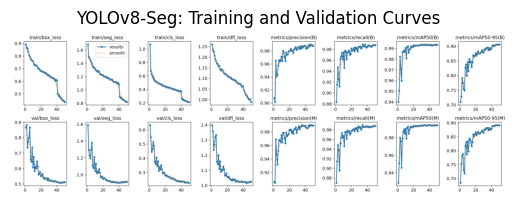

YOLOv8-Seg Performance Metrics:
mAP@0.5: 0.9933
mAP@0.5:0.95: 0.9073
IoU: 0.8924


In [13]:
# === Evaluate YOLOv8-Seg ===
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt

# Load the trained model
model8 = YOLO("/kaggle/working/yolov8_runs/yolov8_seg_train/weights/best.pt")

# Evaluate performance on validation set
metrics8 = model8.val(data="/kaggle/working/dataset.yaml")

# Plot training curves
img_path = "/kaggle/working/yolov8_runs/yolov8_seg_train/results.png"
plt.imshow(plt.imread(img_path))
plt.axis("off")
plt.title("YOLOv8-Seg: Training and Validation Curves")
plt.show()

# Show key metrics
print("YOLOv8-Seg Performance Metrics:")
print(f"mAP@0.5: {metrics8.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics8.box.map:.4f}")
print(f"IoU: {metrics8.seg.map:.4f}")


## Comparison of Predicted Masks vs Ground Truth

After evaluating the YOLOv8 segmentation model, the next step is to **visually compare the predicted masks with the ground truth annotations** for a subset of test images. This helps qualitatively assess the model's segmentation performance.

---

### 1. Sample Selection
- A few random images are selected from the **test set** for visualization.  
- Corresponding YOLO label files are retrieved from the `labels/` directory, assuming the standard YOLO structure.

---

### 2. Ground Truth Visualization
- Ground truth masks are drawn from the YOLO label files.  
- Coordinates are converted from normalized YOLO format to image pixels.  
- Polygons are filled in **green**, with white outlines and class labels for reference.

---

### 3. Predicted Mask Visualization
- Predictions are generated using the trained YOLOv8 model with a confidence threshold of 0.25.  
- Predicted masks are drawn as polygons in **red**, overlaid on the original images.  
- Class labels are displayed on top of each predicted polygon for clarity.

---

### 4. Side-by-Side Comparison
- For each sample image, the **ground truth** and **predicted mask** are displayed side by side using `matplotlib`.  
- This visual comparison allows identification of:
  - Correctly segmented regions
  - Missed or false-positive regions
  - Overall alignment between prediction and ground truth

---

### 5. Objective
This qualitative assessment complements the **quantitative evaluation metrics** (mAP and IoU) by providing an intuitive understanding of how well the YOLOv8 model performs on real test images.  

- **Green polygons** → Ground truth  
- **Red polygons** → Predicted masks  
- **Text labels** → Class names (`affected` and `non`)  

By inspecting these visualizations, one can determine the strengths and limitations of the trained segmentation model in real-world scenarios.



0: 480x640 1 affected, 12.4ms
1: 480x640 1 affected, 12.4ms
2: 480x640 1 affected, 12.4ms
3: 480x640 1 affected, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)


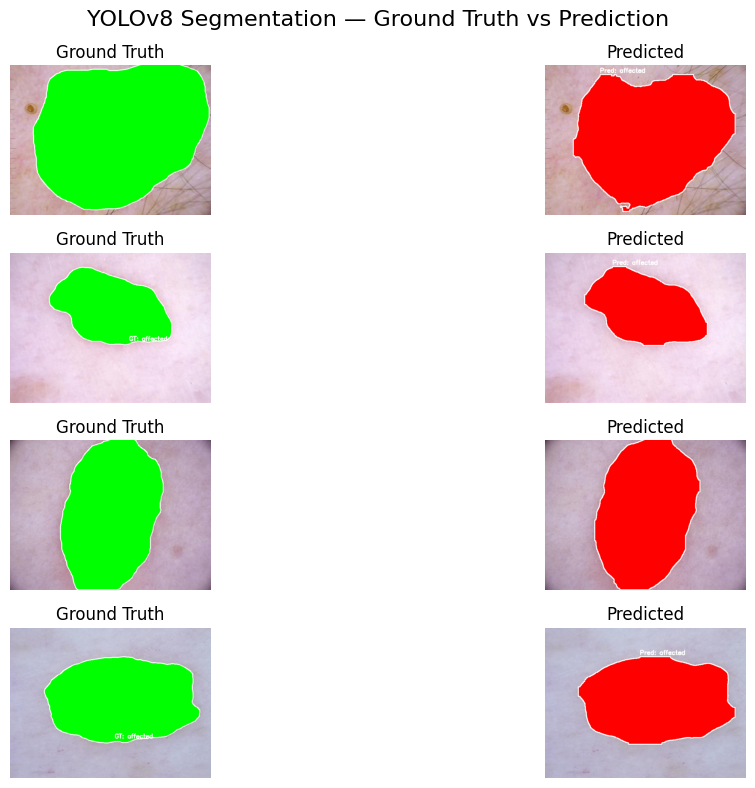

In [14]:
# ============================================================
# YOLOv8 Segmentation — Predicted vs Ground Truth Comparison
# ============================================================

import os, glob, random, cv2
import numpy as np
import matplotlib.pyplot as plt

# Pick a few random test images
test_dir = cfg.get("test")
label_dir = test_dir.replace("/images", "/labels")  # assumes standard YOLO structure

sample_imgs = []
if test_dir and os.path.isdir(test_dir):
    all_imgs = [p for p in glob.glob(os.path.join(test_dir, "*.*"))
                if p.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))]
    sample_imgs = random.sample(all_imgs, min(4, len(all_imgs)))

# ------------------------------------------------------------
# Helper to draw polygons from YOLO label file (Ground Truth)
# ------------------------------------------------------------
def draw_gt_polygons(img_path, label_path, class_names=["affected","non"]):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    overlay = img.copy()

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                vals = list(map(float, line.strip().split()))
                cls_id = int(vals[0])
                coords = vals[1:]
                if len(coords) > 4:
                    pts = np.array(coords).reshape(-1, 2)
                    pts[:, 0] *= w
                    pts[:, 1] *= h
                    pts = pts.astype(np.int32)
                    color = (0, 255, 0)  # green for GT
                    cv2.fillPoly(overlay, [pts], color)
                    cv2.polylines(overlay, [pts], True, (255, 255, 255), 2)
                    label = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
                    cv2.putText(overlay, f"GT: {label}", (pts[0][0], pts[0][1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    else:
        print(f"⚠️ No label file found for {os.path.basename(img_path)}")

    return overlay

# ------------------------------------------------------------
# Helper to draw predicted polygons (YOLOv8)
# ------------------------------------------------------------
def draw_pred_polygons(result):
    img = result.orig_img.copy()

    if getattr(result.masks, "xy", None) is not None:
        for i, seg in enumerate(result.masks.xy):
            poly = np.array(seg, dtype=np.int32)
            color = (0, 0, 255)  # red for predictions
            cv2.fillPoly(img, [poly], color)
            cv2.polylines(img, [poly], True, (255, 255, 255), 2)
            if hasattr(result, "names") and hasattr(result.boxes, "cls"):
                cls_id = int(result.boxes.cls[i].item())
                label = result.names[cls_id] if cls_id in result.names else str(cls_id)
                x, y = poly[0]
                cv2.putText(img, f"Pred: {label}", (int(x), int(y) - 6),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    else:
        print("⚠️ No predicted masks found for:", result.path)

    return img

# ------------------------------------------------------------
# Run inference on test set
# ------------------------------------------------------------
preds = model8.predict(source=sample_imgs, imgsz=640, conf=0.25, device=0, save=False)

# ------------------------------------------------------------
# Plot Predicted vs Ground Truth
# ------------------------------------------------------------
plt.figure(figsize=(14, 8))
for i, result in enumerate(preds):
    img_path = result.path
    label_path = os.path.join(label_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
    
    # Prepare visualizations
    vis_pred = draw_pred_polygons(result)
    vis_gt = draw_gt_polygons(img_path, label_path)

    vis_pred_rgb = cv2.cvtColor(vis_pred, cv2.COLOR_BGR2RGB)
    vis_gt_rgb = cv2.cvtColor(vis_gt, cv2.COLOR_BGR2RGB)

    # Show side by side
    plt.subplot(len(preds), 2, 2*i + 1)
    plt.imshow(vis_gt_rgb)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(len(preds), 2, 2*i + 2)
    plt.imshow(vis_pred_rgb)
    plt.title("Predicted")
    plt.axis("off")

plt.suptitle("YOLOv8 Segmentation — Ground Truth vs Prediction", fontsize=16)
plt.tight_layout()
plt.show()
